In [11]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from scipy import stats
from sklearn.metrics import accuracy_score

batch_size = 128
num_classes = 10
epochs = 12

Using TensorFlow backend.
/home/uttaran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [12]:
def load_data():
    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, x_test,y_train,y_test,input_shape

def create_model(input_shape,feature_maps,kernel,dense):
    model = Sequential()
    model.add(Conv2D(feature_maps, kernel_size=(kernel, kernel),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(2*feature_maps, (kernel, kernel), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(dense, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return  model

def get_teacher_softmax(filename):
    return np.load(filename)

def show_images(data,N):
    for i in range(N):
#         print(np.argmax(teacher_softmaxs[i]))
        plt.imshow(data[i].reshape(28,28))
    
        plt.show()
        
def train_model(model,x,y,x_test,y_test,filename):
    model.fit(x, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    model.save(filename+'.h5')

def evaluate(models,x_test,y_test):
    predictions=[]
    for model in models:
        predictions.append(np.argmax(model.predict(x_test),axis=1))
    class_predictions = stats.mode(predictions)
    accuracy = accuracy_score(y_test, class_predictions)
    print("Accuracy = ",accuracy,"%")

In [13]:
#Main
l=0.5
x_train,x_test,y_train,y_test,input_shape=load_data()
teacher_softmaxs=get_teacher_softmax("teacher_mnist_softmax.npy")
y_true_modified =  l*y_train + (1-l)* teacher_softmaxs

model1=create_model(input_shape,4,3,16)
model2=create_model(input_shape,4,3,16)
model3=create_model(input_shape,4,3,16)
model4=create_model(input_shape,4,3,16)

# show_images(x_train,10)

# print(np.argmax(y_true_modified[:10],axis=1))

train_model(model1,x_train,y_true_modified,x_test,y_test,"model1")
train_model(model2,x_train,y_true_modified,x_test,y_test,"model2")
train_model(model3,x_train,y_true_modified,x_test,y_test,"model3")
train_model(model4,x_train,y_true_modified,x_test,y_test,"model4")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 5s 91us/step - loss: 0.9817 - acc: 0.6381 - val_loss: 0.1967 - val_acc: 0.9477
Epoch 2/12
60000/60000 [==============================] - 4s 66us/step - loss: 0.6526 - acc: 0.7550 - val_loss: 0.1469 - val_acc: 0.9622
Epoch 3/12
60000/60000 [==============================] - 4s 70us/step - loss: 0.5957 - acc: 0.7740 - val_loss: 0.1236 - val_acc: 0.9672
Epoch 4/12
60000/60000 [==============================] - 4s 68us/step - loss: 0.5619 - acc: 0.7875 - val_loss: 0.1091 - val_acc: 0.9713
Epoch 5/12
60000/60000 [==============================] - 4s 68us/step - loss: 0.5453 - acc: 0.7932 - val_loss: 0.1030 - val_acc: 0.9732
Epoch 6/12
60000/60000 [==============================] - 4s 66us/step - loss: 0.5178 - acc: 0.8036 - val_loss: 0.0927 - val_acc: 0.9733
Epoch 7/12
60000/60000 [==============================]

In [7]:
np.argmax(model.predict(x_test),axis=1)

In [16]:
model4.evaluate(x_train,y_true_modified)

60000/60000 [==============================] - 4s 63us/step


[0.08793179097572962, 0.97715]

In [9]:
a=[[1,2, 4], [1, 5,3],[4,5,4] ]



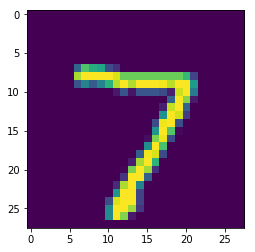

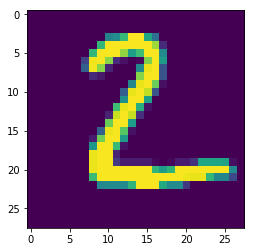

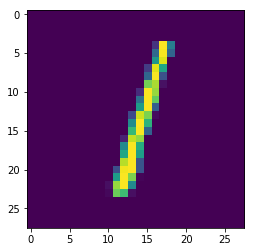

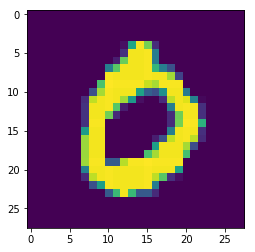

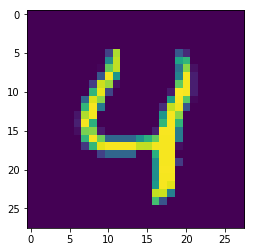

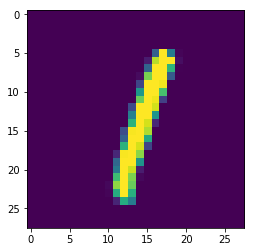

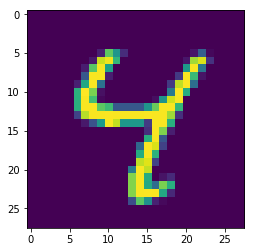

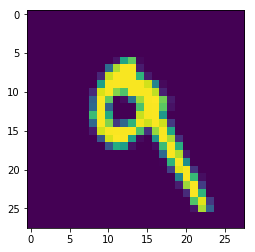

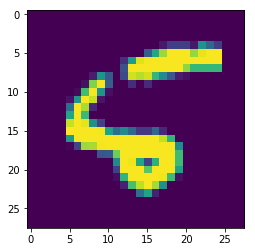

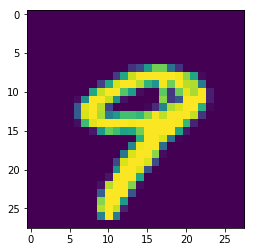

In [19]:
show_images(x_test,10)

In [22]:
np.argmax(y_test[:10],axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [ ]:
model5=create_model(input_shape,4,3,16)
epochs=1
batch_size = 1500
train_model(model5,x_train,y_true_modified,x_test,y_test,"model5")

In [28]:
print(model5.evaluate(x_test,y_test))
print(model5.evaluate(x_train,y_train))

10000/10000 [==============================] - 1s 67us/step
[0.23053752998113633, 0.9455]
60000/60000 [==============================] - 4s 65us/step
[0.24591355386972427, 0.9408166666666666]
